# Exploitation: LE RETOUR
<img width=300px src="https://pbs.twimg.com/profile_images/496812657341890561/m9vimoug.jpeg">

In [1]:
import torch
from torch.utils.data import DataLoader
from src.final_model_log_scale import WAE, AudioDataset

from src.util import audio_utilities as au

import librosa as li

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from IPython.display import Audio

import numpy as np

model = torch.load("pretrained/model_before_nan.pt", map_location="cpu")

motu  = DataLoader(AudioDataset("notebooks/motu/motu_dataset/*.wav", process=True, slice_size=128), batch_size=20, shuffle=True, drop_last=True)

Preprocessing audio dataset... 
[====

KeyboardInterrupt: 

In [27]:
def show_spec(X):
    """Affiche un spectrogramme"""
    plt.figure(figsize=(15,10))
    plt.imshow(X, origin="lower", aspect="auto")
    plt.show()
    
def GL_1pass(X, partial=False):
    """Une passe de Griffin Lim. L'argument partial définit si l'intégralité de la phase est recherchée
    ou si juste la motié droite du spectrogramme est reconstruite"""
    N = X.shape[0]
    
    x = au.istft_for_reconstruction(X, 2048, 256)
    X_ = au.stft_for_reconstruction(x, 2048, 256)
    
    if partial:
        angle = np.angle(X_)
        Y = abs(X).astype(complex)
        Y[N//2:] *= np.exp(1j*angle[N//2:])
        Y[:N//2] = X[:N//2]
    else:
        angle = np.angle(X_)
        Y = abs(X).astype(complex)
        Y *= np.exp(1j*angle)
        
    return Y

def GL(X, iteration, partial=False):
    """Fais pleins de fois GL_1pass"""
    X = X.astype(complex)
    for i in range(iteration):
        X = GL_1pass(X, partial=partial)
    return X

def rec(X):
    return au.istft_for_reconstruction(X, 2048, 256)
    
def listen(out):
    return rec(li.filters.mel(22050, 2048, 500).T.dot(out))
    
mel = li.filters.mel(22050, 2048, 500)
#X = mel.T.dot(X).T.astype(complex)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for idx, (minibatch, f) in enumerate(motu):
    minibatch = minibatch.to(device)
    z = model.encode(minibatch)

z = z.detach().cpu().numpy()

del(minibatch)
torch.cuda.empty_cache()

ValueError: too many values to unpack (expected 2)

In [17]:
z_embedded = TSNE().fit_transform(z)
print("Embedded latent space of dimension %d into %d dimensions" % (z.shape[1], z_embedded.shape[1]))

Embedded latent space of dimension 32 into 2 dimensions


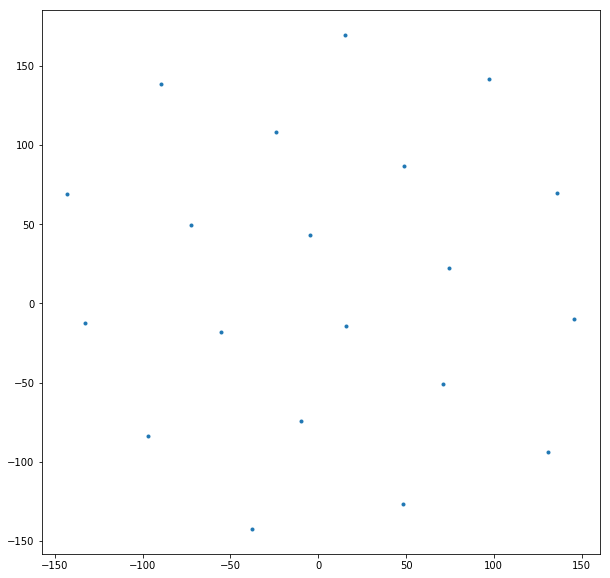

In [18]:
plt.figure(figsize=(10,10))
plt.plot(z_embedded[:,0], z_embedded[:,1], '.')
plt.show()

In [19]:
gp1_x = z_embedded[:,0] < -4.5
gp1_y = z_embedded[:,1] > 6

gp1   = z[gp1_x*gp1_y,:]

print(gp1.shape)

(5, 32)


In [20]:
model.n_trames = 128
out = model.decode(torch.from_numpy(gp1).to(device)).detach().cpu().numpy()

TypeError: decode() missing 1 required positional argument: 'f'

## test modèle semi supervisé

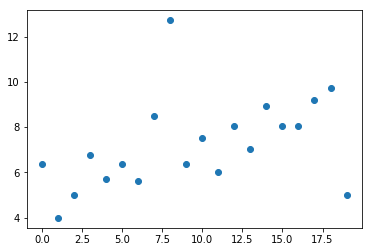

In [20]:
model = torch.load("pretrained/motu_supervised_2_900_epoch.pt")

motu  = DataLoader(AudioDataset("notebooks/motu/motu_dataset/*.wav", process=False, slice_size=128), batch_size=20, shuffle=False, drop_last=True)

spec, freq = next(iter(motu))
spec = spec.to(device)
freq = freq.to(device).unsqueeze(1)


plt.plot(freq.cpu().detach().numpy(), 'o')

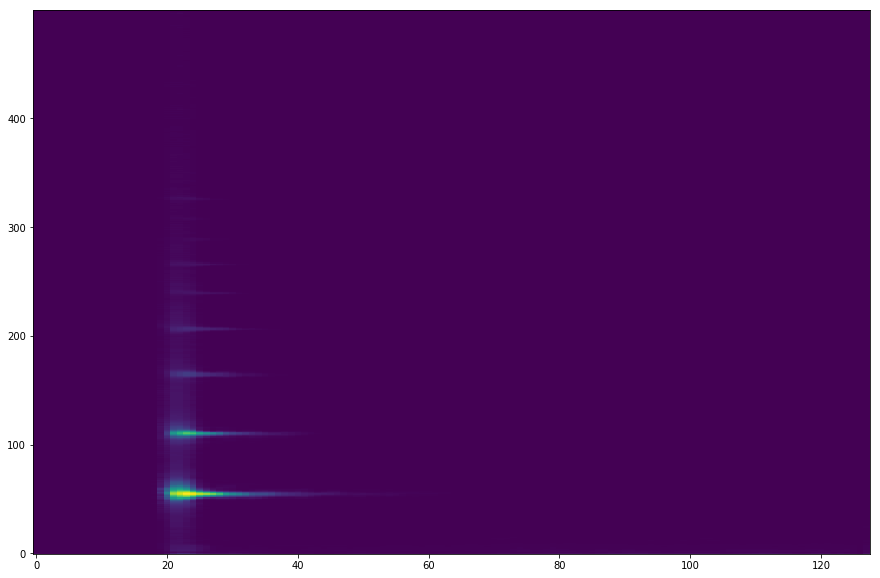

In [19]:
out = model(spec,freq).detach().cpu().numpy()

show_spec(out[4,:,:])

In [7]:
model, log = model

(-200, 30)

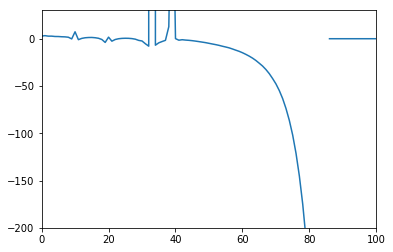

In [18]:
plt.plot(log)
plt.xlim([0,100])
plt.ylim([-200, 30])

TypeError: 'DataLoader' object does not support indexing

In [29]:
x = torch.Tensor([1e-7]).float().to(device)

In [32]:
500/x

tensor([5.0000e+09], device='cuda:0')

In [8]:
for elm in model[0].parameters():
    try:
        torch.nn.init.xavier_normal_(elm)
    except:
        pass

In [13]:
for elm in model[0].parameters():
    print(elm)

Parameter containing:
tensor([[[[ 1.9476e-02, -2.3988e-02, -1.1794e-02, -2.8931e-02, -7.6921e-04],
          [-1.9960e-02,  1.4277e-02,  1.5215e-02, -1.2252e-02,  1.5949e-02],
          [-1.1424e-02, -1.7802e-02, -1.7030e-02, -3.1495e-02, -2.1142e-02],
          [-1.1755e-02, -9.8860e-03, -1.8887e-02,  4.8704e-03,  9.0844e-03],
          [ 4.5847e-02, -3.1533e-02,  1.9125e-02, -1.0726e-02,  1.2148e-02]],

         [[-3.5995e-03, -1.1142e-02,  4.1904e-03, -1.4419e-02,  6.4800e-03],
          [ 1.5029e-03, -5.8389e-03, -1.1382e-02, -9.9838e-03,  1.5996e-02],
          [ 8.4910e-03,  7.3818e-03, -1.3424e-02,  1.9674e-02, -1.4539e-02],
          [ 1.7851e-02,  9.4189e-03,  1.6349e-02, -1.2948e-03, -3.0913e-03],
          [-2.4650e-02, -5.0413e-04, -2.1769e-03, -1.9258e-02,  1.4179e-03]],

         [[ 4.1539e-03,  1.9674e-02, -1.7278e-02,  1.1792e-02,  1.6421e-02],
          [ 9.5111e-03, -1.5766e-02, -7.3335e-03, -3.7319e-03, -1.6353e-02],
          [ 2.1072e-02,  8.7510e-03, -3.9808e-03, 